# 0010-SRT-pilot

This experiment was conducted by Kathryn Schuler in collaboration with Elissa Newport (advisor), Darlene Howard, & Jim Howard.  The lab manager at the time of running was Katherine Olson and the research assistant who collected the data was Jason Sotomayor.  The data was collected at Georgetown University from October 23, 2012 to November 15, 2012.

This is a simple serial reaction time tast (SRT) in which participants see a screen with 4 circles.  When a circle fills, they must touch the corresponding keyboard button (z, x, n, m) as quickly and accurately as possible.  We measure their accuracy and reaction time over 20 blocks of 80 trials.  Faster reaction times reveal learning.




- [Introduction]()
- [Materials and method](##Materials-and-Method)
    - [Subjects]()
    - [Materials](Materials)
    - [Procedure](Procedure)
- [Results and analysis]()
    - [Setting up]()
    - [Data cleaning]()
    - [Accuracy]()
    - [Reaction Time]()
        - [Raw RT]()
        - [Normalized RT](z-score)
- [Conclusions & next steps]()
- [File locations]()



## Introduction

0010-SRT-pilot was the first experiment Lissa and I ever conducted at Georgetown.  We wanted to see if we could replicate the Howard's SRT task in our own lab.  We began with this simple regular serial reaction time task (SRT), where every transition in the pattern was 100% predictable (i.e. a series of 8 button presses repeated over and over again).



## Materials and Method

### Subjects
- 20 GU undergrads (2 excluded for not finishing)
- Conducted in the Newport Lab
- Compensated $10 

### Materials
- Hardware: Mac-mini, keyboard
- Software: PsychoPy, Python
- 4 circles aligned horizontally across the screen each of which corresponds to 4 keyboard buttons [z,x,n,m]
- Each participant assigned to a series of 8 button presses that would repeat over and over (SRT)

### Procedure
- Circles fill green according to the serial pattern the participant was assigned to
- Participants must press the keyboard button that corresponds to the illuminated circle.
- They are instructed to work as quickly and as accurately as possible.
- Every 80 trials (1 block) subjects are given a 60 second break.  They complete 20 blocks.

## Results and Analysis

Data analysis was conducted with R.  In this (and all) SRT experiments, we perform three main analyses.
- Accuracy: Does participant accuracy change as a function of time?
- Raw RT: Does raw reaction time change as a function of time?
- Normalized RT: We z-transform as a way of normalizing RT data, an analyze zRT as a function of time.


### Setting up
We begin by loading the required packages and adjusting the size of the figure output

In [68]:
# load the R libraries we need
library(ggplot2)
#install.packages("doBy", repos = "http://cran.rstudio.com/")
library(doBy)

# adjust figure output size
options(repr.plot.width = 5)
options(repr.plot.height = 3)

### Data Cleaning

Before we compute accuracy and reaction time, we need to clean our data a little bit.  With reaction time data, there isn't really a standard procedure that everybody uses for eliminating outliers.  Some people use 2SD away from the mean, some people make a cutoff threshold (e.g. <1000ms) and remove any trials beyond it, some people normalize and then remove, etc.  In addition, the Howards like to remove participants who have accuracy levels below 80%, which is typically an indicator that they did not understand the task (or were not "doing their best")

We will adopt this strategy here:
- inspect the data visually to determine a reasonable cutoff criteria (usually 1000ms)
    - the goal here is remove extreme values.
- remove participants below 80% (to be consistent with the Howards)

#### Outlier elimination
Visually inspect the data and cutoff values beyond 1000ms if reasonable.

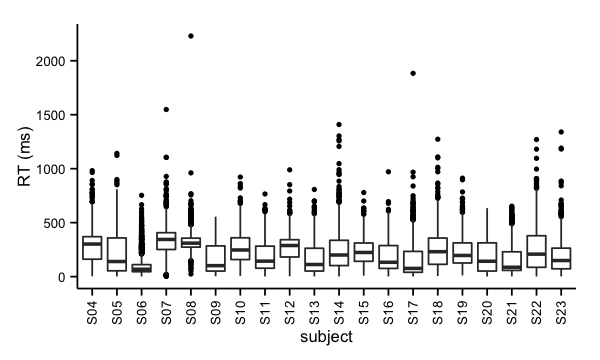

In [69]:
# load data
orig.data = read.csv("processed-data/0010-srt-pilot-processed-data.csv")

# convert seconds to ms
orig.data$RT = orig.data$RT*1000

# boxplot to inspect for outliers
ggplot(orig.data, aes(x=sid, y=RT)) + geom_boxplot(outlier.size = 1.5) + theme_classic(base_size=10) + 
    xlab('subject') + ylab('RT (ms)') +
    theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5))

We can see by looking at the data that there aren't any extremely ridiculous outliers.  In my opion, it actually makes more sense to leave these outliers in, rather than selecting some arbitrary cutoff criteria.  Later we are going to later take the median RT, anyway, which is pretty resiliant to outliers.  These few outling points are hardly going to make a difference.  However, just to be consistent across studies, we will remove trials with RTs exceeding 1000ms. 

In [4]:
# remove trials with RT greater than or equal to 1000ms
data.rm.extrmRT = subset(orig.data, RT <= 1000)

# figure out how much data was lost
n.outliers = nrow(orig.data) - nrow(data.rm.extrmRT)
data.loss = n.outliers/nrow(orig.data) * 100 
cat("Number of outliers: ", n.outliers, "  Data loss: ", data.loss, "%")

Number of outliers:  24   Data loss:  0.075 %


#### Remove participants with accuracy below 80%
Next we will remove participants with overall accuracy below 80%.

In [5]:
# make function to compute percent correct (pcntc)
pcnt.correct = function (x) return (sum(x)/length(x)*100)

# get the overall accuracy for each subject and inspect
overall.acc = summaryBy(isCorrect ~ sid, data = data.rm.extrmRT, FUN = pcnt.correct)
print(overall.acc)

   sid isCorrect.pcnt.correct
1  S04               86.81250
2  S05               96.93367
3  S06               92.81250
4  S07               92.86162
5  S08               86.05378
6  S09               96.43750
7  S10               87.75000
8  S11               86.12500
9  S12               97.06250
10 S13               85.18750
11 S14               90.58971
12 S15               92.06250
13 S16               93.68750
14 S17               64.35272
15 S18               93.91850
16 S19               92.87500
17 S20               86.81250
18 S21               91.18750
19 S22               91.35880
20 S23               94.55229


We can see that only one subject (S17) has overall accuracy below 80%.  Let's remove that participant to complete our data cleaning.

In [6]:
# remove subjects below 80%
data.rm.lowAcc = subset(data.rm.extrmRT, sid != "S17")

# Check how much data was lost
n.outliers = nrow(data.rm.extrmRT) - nrow(data.rm.lowAcc)
data.loss = n.outliers/nrow(data.rm.extrmRT) * 100 
cat("Number of outliers: ", n.outliers, "  Data loss: ", data.loss, "%")

Number of outliers:  1599   Data loss:  5.000625 %

We see that this results in a bit more data loss (quite a bit in my opinion).  It is still a reasonable number, but I don't love it.  We could probably have left this person in without effecting our overall results at all.  Going forward, a better way of handling this is probably adding accuracy as predictor in our model (instead of excluding people based on accuracy criteria).  

### Accuracy

Now we can compute mean accuracy by block for the remaining 19 subjects.  Note that the graph below is presenting values between 88 and 98%.  This is to help demonstrate some nuanced differences in accuracy across blocks (especially between blocks 1 and 2).  It is important to keep in mind that, in general, participants maintain extremely high accuracy across all blocks.

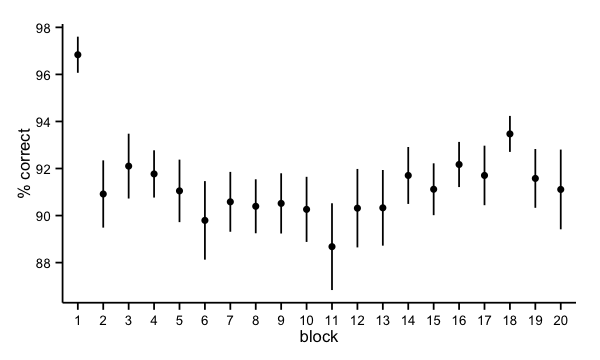

In [70]:
# compute each subject's % correct by block
acc.sid.block = summaryBy(isCorrect ~ sid*block, data = data.rm.lowAcc, FUN = pcnt.correct )

# plot mean % correct by block
ggplot(acc.sid.block, aes(factor(block), isCorrect.pcnt.correct)) +
    stat_summary(fun.data = mean_se, size = 0.5, geom="pointrange", position = "dodge") +
    theme_classic(10) + theme(legend.position = "bottom") +
    xlab("block") + ylab("% correct") 

### Reaction time 


Next we will analyze the reaction time data for our remaining 19 subjects.  To do so, we need to first do a bit more data cleaning (Howard & Howard, 1997)

#### Remove incorrect trials
We need to remove any trials that were incorrect.  Although these might be informative in some way, they are impossible to interpret. (Did the subject make a mistake completely irrelevant to our manipulation? or did the subject make a mistake that tells us what he/she was predicting to happen, even though it wasn't exactly right?)  For now, we will remove them.  

In [22]:
# used the previously cleaned data set and additionally remove incorrect trials
data.rm.incorrect = subset(data.rm.lowAcc, isCorrect == 1)

# Check how much data was lost 
n.outliers = nrow(data.rm.lowAcc) - nrow(data.rm.incorrect)
data.loss = n.outliers/nrow(data.rm.lowAcc) * 100 
cat("Number of outliers: ", n.outliers, "  Data loss: ", data.loss, "%")


Number of outliers:  2637   Data loss:  8.68091 %

#### Raw RT


With the cleaned data set, we calcuate median RT for each participant for each block and then take the mean of those median RTs (Howard & Howard, 1997) .

#### Median RT by subject by block
We can plot the median RT for each participant for each block, which gives us each participants learning curve.

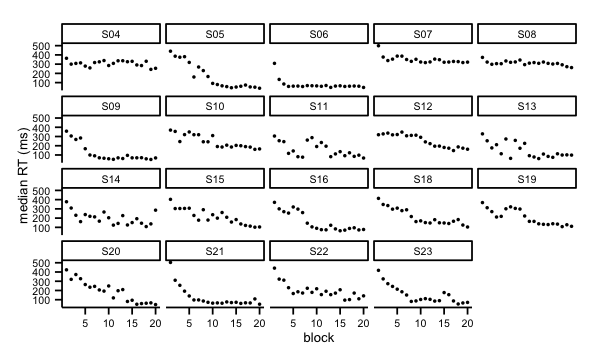

In [71]:
# individual subject data for mean of median RT
medianRT.block = summaryBy(RT ~ sid*block, data = data.rm.incorrect, FUN = median, var.name = "block")

# plot median RT by subject
ggplot(medianRT.block, aes(block, block.median, ymax = max(block.median))) + 
       geom_point(stat="identity", position = "dodge", size = 1) +
       facet_wrap(~sid) + theme_classic(base_size=8) + ylab("median RT (ms)")

This looks great - we can see that each participant has a different learning curve, but the overall pattern is the similar (they get faster over time).  However, it also demonstrates the utility of normalizing the RTs. The Howard & Howard analysis method takes the mean of these median reaction time to give the final data used for analysis.  Normalizing the RTs might help this situation.  (However, going forward we might want to use a mixed-effect model)

#### Mean of median RT

Now we can compute the mean of median reaction times by block to show the group learning effects.

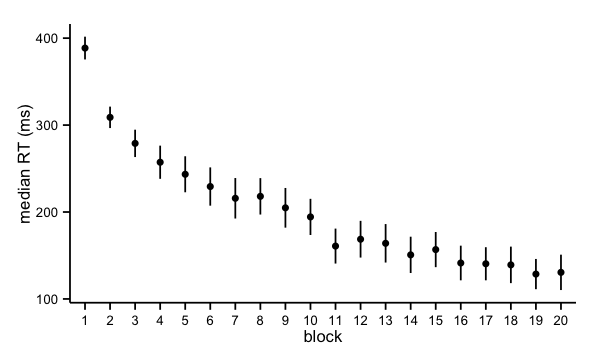

In [72]:
# plot the mean of median RT
ggplot(medianRT, aes(factor(block), RT.median)) + 
    stat_summary(fun.data=mean_se, size = 0.5, geom= "pointrange", position = "dodge") +
    theme_classic(base_size=10) + ylab("median RT (ms)") + xlab("block")


### Normalized RT

The most popular options for normalizing RT data in the literature are proportional transformations and z-score transformations.  Z-score transforms are preferred (by us and other labs), because proportional transforms are not as good at controlling for differences in processing speed (age-related or otherwise).  This is because proportional transformations assume that the function relating processing speed between two groups is linear, with an intercept of zero, which is not always valid (e.g. Chris, et al, 2001; Faust, Balota, Speiler, & Ferrar, 1999).

#### Compute median modified z-score
To compute z-score, we follow what has been suggested previously (e.g. Praat, Abrams, & Chasteen, 1997), with modifications for computing z-scores based on median and median absolute deviations (rather than mean and standard deviation):

 - For each participant, we computed an overall median RT and median absoulte deviation (MAD)
 - Then, we subtracted this overall median RT from the participant’s median RT for each block.
 - We multiplied this result by the constant 0.6745, as recommended by Iglewicz & Hoaglin (1993) for z-scored medians.
 - Then we divided this value by the participant’s overall median absolute deviation (MAD) (again, as Iglewicz & Hoaglin suggest).


In [52]:
# compute overall median RT and MAD from correct trials
medianRT.overall = summaryBy(RT ~ sid, data = data.rm.incorrect, FUN = list(median, mad), var.name = "overall")

# subtract overall median RT from block median RT by participant
z.data = merge(medianRT.block, medianRT.overall, by = 'sid')

# compute median modified z-score
z.data$z.RT = (0.6745*(z.data$block.median - z.data$overall.median))/z.data$overall.mad

#### Median RT by subject by block
Now we can once again plot by block for each individual, this time with the normalized RT.


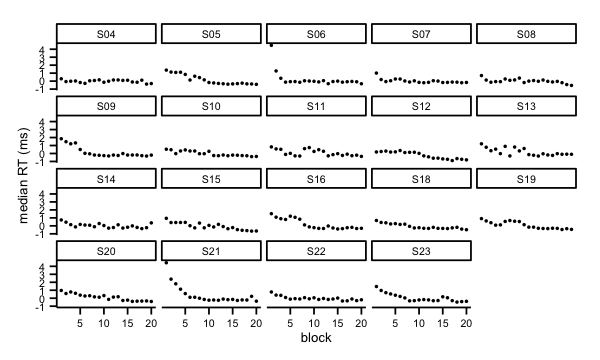

In [73]:
# plot median RT by subject
ggplot(z.data, aes(block, z.RT, ymax = max(z.RT))) + 
       geom_point(stat="identity", position = "dodge", size = 1) +
       facet_wrap(~sid) + theme_classic(base_size=8) + ylab("median RT (ms)")


#### Mean of median RT
Now we can compute the mean of these z transformed median reaction times by block to show the group learning effects.

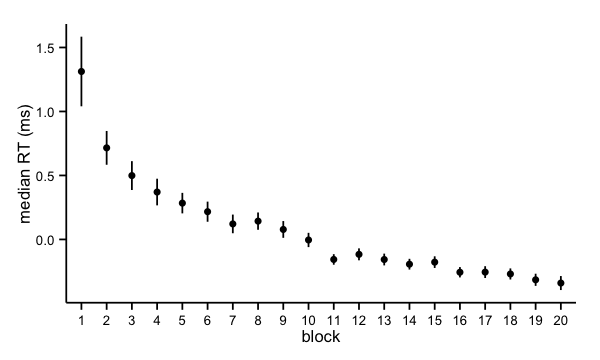

In [74]:
# plot the mean of z RT
ggplot(z.data, aes(factor(block), z.RT)) + 
    stat_summary(fun.data=mean_se, size = 0.5, geom= "pointrange", position = "dodge") +
    theme_classic(base_size=10) + ylab("median RT (ms)") + xlab("block")

## Conclusions & next steps

### People can learn this (at different rates)
Now let's take a look at the overal median and mad for each partipant, just to inspect things a little bit.  We can see in the table below that the overal medians are widely variable for each participant. Some of the overall median values are in fact extremely fast. S06 has an overall median of 65.51 ms, for example, well below the phisiologically possible RT to a visual stimulus (typcially 100ms in humans).  What does this mean?  First, RTs below 100ms typically indiate **anticipatory** reaction times.  The fact that S06 (and others) had anticipatory reaction times as their overall reaction time tells us that they learned extremely fast.  This makes a lot of sense when you think about how simple the actual task was (the same exact 4 button sequence repeated over and over for 1600 trials).    Participants who have much longer overall reaction times also tend to have much larger median absoulte deviations, meaning that their reaction times are significantly changing over blocks - suggesting they take longer to learn.

In [53]:
print(medianRT.overall)

   sid overall.median overall.mad
1  S04      310.42504   122.06986
2  S05      130.61285   151.45496
3  S06       65.51409    36.51619
4  S07      347.18609   101.71511
5  S08      310.70447    59.96071
6  S09       96.84992    95.24962
7  S10      249.34149   151.56913
8  S11      140.38563   134.37978
9  S12      289.13713   107.06466
10 S13      116.69183   117.79524
11 S14      194.27502   166.40714
12 S15      225.41189   126.82310
13 S16      125.90504   108.14985
14 S18      233.35052   180.77784
15 S19      195.57297   128.07795
16 S20      159.22117   183.44696
17 S21       86.25197    63.32477
18 S22      202.08192   206.86285
19 S23      143.80145   126.10236


### Next steps
We acheived our original goal of replicating an SRT paradigm.  We know that Katie's paradigm is working, and we can move on to replicating the alternating serial reaction time task. (aSRT task)

## Important files
Files can be found on Katie's local computer at the path described, or you can access it on dropbox by clicking the link. All local paths are relative to `/Users/kathrynschuler/Documents/research-gu/`

- [Summary (pdf version of this document)]: `summaries/`
- [Stimuli](https://www.dropbox.com/sh/zfs3kwopxgktvff/AAA665qHEAr6Rp4DEB4nMH9ga?dl=0): `stimuli/0010-str-pilot-stims/`
- [Experiment](): `experiment-code/0010-srt-pilot-exp/`
- [Analysis](): `somewhere`
- [Figures](https://www.dropbox.com/sh/ex3ma6g4u124bi7/AACZct7dUlb4hfPqruhaoa1oa?dl=0): `figures/0010-srt-pilot-figs/`

